In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using Interpolations
using MCMCChains
using CSV 


discourse.julialang.org/t/is-there-a-turing-alternative-to-pm-deterministic-from-pymc3/38667

https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Latent.html

In [2]:
# Squared-exponential covariance function
sqexp_cov_fn(D, mu, phi) = @.(mu * exp(-D^2 / (2*phi))) + 0.05 * LinearAlgebra.I
# Exponential covariance function
exp_cov_fn(D, mu, phi) = @.(mu * exp(-D / phi)) + 0.05 * LinearAlgebra.I

exp_cov_fn (generic function with 1 method)

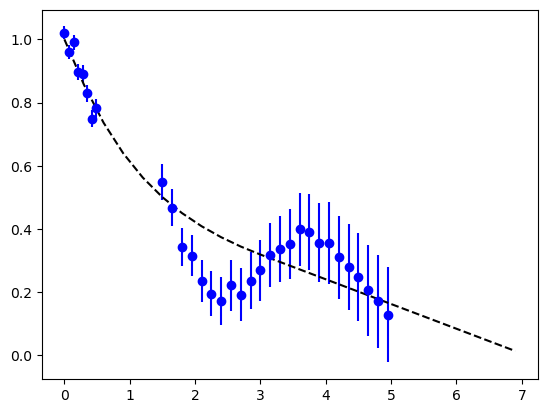

8
24


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6a814ec190>

In [99]:
cosmology = Cosmology()
data_1_x = Vector(0:0.07:0.5) 
println(length(data_1_x))
data_2_x = Vector(1.5:0.15:5)
println(length(data_2_x))
data_x = zeros(length(data_1_x)+length(data_2_x), 1)
data_x[1:length(data_1_x), 1] = data_1_x
data_x[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = data_2_x
N = length(data_x)

data = similar(vec(data_x))
data[1:length(data_1_x), 1] = cosmology.Dz(vec(data_1_x)) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = cosmology.Dz(vec(data_2_x)) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
#data = cosmology.Dz(vec(data_x)) .* (1 .+ 0.5 .* (sin.(vec(data_x)./0.5) + randn(N) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * vec(data_x))))
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo")
gp_x = Vector(0:0.3:7)
gp_N = length(gp_x)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "k--")

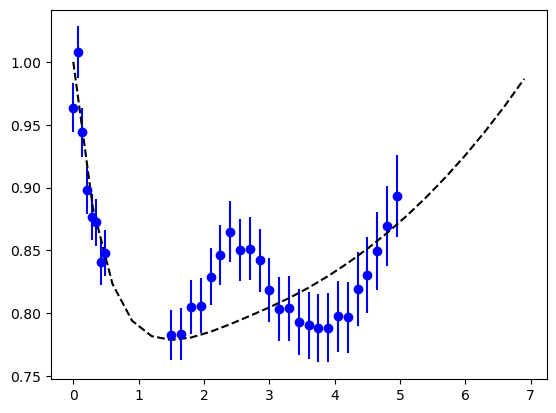

(PyObject <matplotlib.lines.Line2D object at 0x7f6aa0b888b0>, (), (PyObject <matplotlib.collections.LineCollection object at 0x7f6aa0b88a90>,))

In [4]:
function make_non_lin(y)
    return @. exp(-y + y^2)
end

nonlin_data = make_non_lin(data)
nonlin_data_err = vec(@.((0.02 * nonlin_data) + (0.003 * vec(data_x))))

plt.plot(gp_x, make_non_lin(cosmology.Dz(gp_x)), "k--")
plt.errorbar(vec(data_x), nonlin_data, yerr=nonlin_data_err, fmt="bo")


In [5]:
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

nonlin_data_cov = zeros(N, N)
for i in 1:N
    nonlin_data_cov[i,i] = nonlin_data_err[i]^2 
end

In [6]:
function model_latent_GP(mu, phi, v; 
                         X=data_x, data_cov=data_cov, cov_fn=sqexp_cov_fn, cosmology=Cosmology())
    # Dimensions of predictors .
    N, P = size(X)
    gp_x = Vector(0:0.3:7)
    gp_N = length(gp_x)
    Q = N + gp_N
    Z = [X; gp_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    Dz_gp = cosmology.Dz(vec(gp_x))
    
    # Set up GP
    K = cov_fn(D, mu, phi)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N]             # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    #rand(MvNormal(zeros(gp_N), 0.1*ones(gp_N)))
    gp = Dz_gp .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    m = C * gp
    nonlin_y = make_non_lin(m)
    return gp, m, nonlin_y
end

model_latent_GP (generic function with 1 method)

In [7]:
N_samples = 100
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
nonlin_ys=zeros(N_samples, 32)
for i in 1:N_samples
    mu = rand(Exponential(1))
    phi = rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(gp_N), 0.1 .* ones(gp_N)))
    gps[i, :], ys[i, :], nonlin_ys[i, :] = model_latent_GP(mu, phi, v)
end

y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
nonlin_y_m, nonlin_y_s = mean(nonlin_ys, dims=1), std(nonlin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

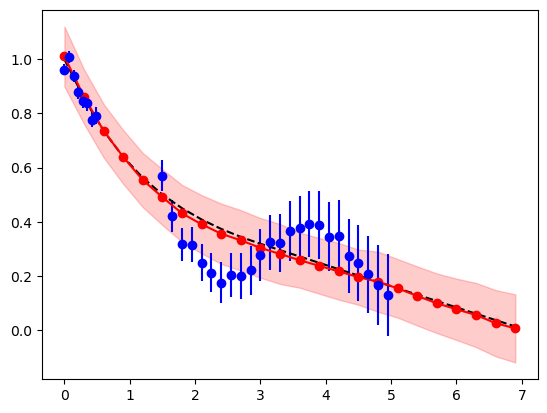

PyObject <matplotlib.collections.PolyCollection object at 0x7f6a989aa0d0>

In [8]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "ro-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")

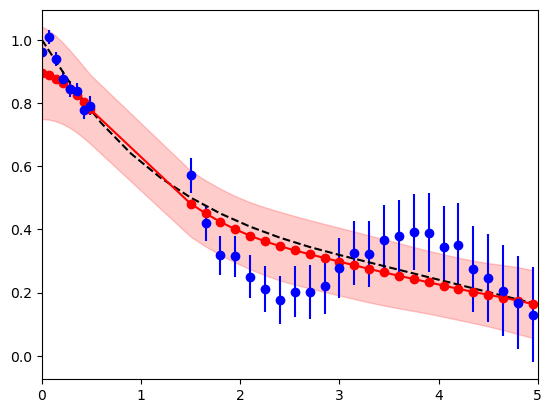

(0.0, 5.0)

In [9]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(data_x), vec(y_m), "ro-")
plt.fill_between(vec(data_x), vec(y_m .+ y_s),  vec(y_m .- y_s), alpha=0.2, color="red")
plt.xlim(0., 5.)

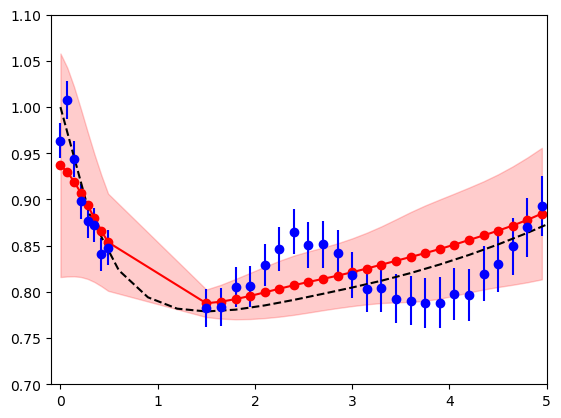

(-0.1, 5.0)

In [10]:
plt.plot(gp_x, make_non_lin(cosmology.Dz(gp_x)), "k--")
plt.errorbar(vec(data_x), nonlin_data, yerr=nonlin_data_err, fmt="bo")

plt.plot(vec(data_x), vec(nonlin_y_m), "ro-")
plt.fill_between(vec(data_x), vec(nonlin_y_m .+ nonlin_y_s),
                 vec(nonlin_y_m .- nonlin_y_s), alpha=0.2, color="red")

plt.ylim(0.7, 1.1)
plt.xlim(-0.1, 5.)

In [114]:
@model function latent_GP(y; X=data_x, data_cov=nonlin_data_cov, cov_fn=sqexp_cov_fn, cosmology=Cosmology())
    # Dimensions of predictors .
    N, P = size(X)
    gp_x = Vector(0:0.3:7)
    gp_N = length(gp_x)
    Q = N + gp_N
    Z = [X; gp_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    Dz_gp = cosmology.Dz(vec(gp_x))
    
    # Priors.
    mu ~ Exponential(1)
    phi ~ Uniform(0.1, 3)
    
    # Set up GP
    K = cov_fn(D, abs(mu), phi)
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Knn = K[1:N, 1:N] + data_cov  # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    
    v ~ MvNormal(zeros(gp_N), 0.3 .* ones(gp_N))
    gp = Dz_gp .+ cholesky(Koo).U' * v
    # Conditional 
    Koo_inv = inv(Koo)            
    C = Kno * Koo_inv
    m = C * gp
    y ~ MvNormal(make_non_lin(m), data_cov)
end

latent_GP (generic function with 1 method)

In [115]:
cycles = 1
iterations = 1000
TAP = 0.60
adaptation = 500
#nchains = Threads.nthreads()

# Start sampling.
folpath = "chains_tests/"
folname = string("test_", "TAP", TAP)
folname = joinpath(folpath, folname)

mkdir(folname)
println("Created new folder")

for i in 1:cycles
    if i == 1
        chain = sample(latent_GP(nonlin_data), NUTS(adaptation, TAP), 
                       iterations, progress=true; save_state=true)
    else
        old_chain = read(joinpath(folname, string("chain_", i-1, ".jls")), Chains)
        chain = sample(latent_GP(nonlin_data), NUTS(adaptation, TAP), 
                       iterations, progress=true; save_state=true,
                       resume_from=old_chain)
    end 
    write(joinpath(folname, string("chain_", i,".jls")), chain)
end

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
Sampling:  28%|███████████▌                             |  ETA: 0:04:22┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:04:39


Created new folder


In [116]:
chain =  read(joinpath(folname, string("chain_1.jls")), Chains);
summary = describe(comb_chain)[1]
internals = chain.name_map.internals
params = chain.name_map.parameters
params = append!(internals, params)
comb_data = chain.value.data
i = 2
fname = joinpath(folname, string("chain_", i,".jls")) 
while isfile(fname)
    loaded_chain =  read(joinpath(folname, string("chain_1.jls")), Chains)
    comb_data = [comb_data; loaded_chain.value.data]
    i = i + 1
    fname = joinpath(folname, string("chain_", i,".jls")) 
end
comb_chain = Chains(comb_data, params, Dict(:internals => internals))
comb_summary = describe(comb_chain)[1]
CSV.write(joinpath(folname, "summary.csv"), comb_summary)
CSV.write(joinpath(folname, "chain.csv"), comb_chain)

"chains_tests/test_TAP0.6/chain.csv"

In [123]:
chain =  read(joinpath(folname, string("chain_1.jls")), Chains);
mu_p = group(chain, :mu).value.data[:, :, 1]
phi_p = group(chain, :phi).value.data[:, :, 1]
v_p = group(chain, :v).value.data[:, :, 1];

In [124]:
N_samples = length(mu_p)
gps=zeros(N_samples, 24)
ys=zeros(N_samples, 32)
nonlin_ys=zeros(N_samples, 32)
for i in 1:N_samples
    gps[i, :], ys[i, :], nonlin_ys[i, :] = model_latent_GP(mu_p[i], phi_p[i], v_p[i, :])
end

In [125]:
y_m, y_s = mean(ys, dims=1), std(ys, dims=1);
nonlin_y_m, nonlin_y_s = mean(nonlin_ys, dims=1), std(nonlin_ys, dims=1);
gp_m, gp_s = mean(gps, dims=1), std(gps, dims=1);

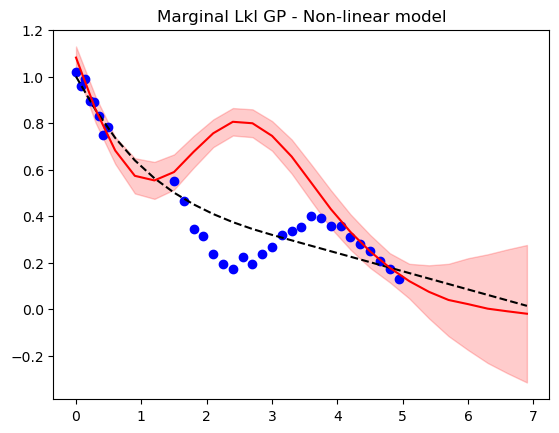

PyObject Text(0.5, 1.0, 'Marginal Lkl GP - Non-linear model')

In [126]:
plt.plot(vec(data_x), data, "bo", label="Data")
plt.plot(gp_x, cosmology.Dz(gp_x), "k--", label="LCDM")
plt.plot(vec(gp_x), vec(gp_m), "r-")
plt.fill_between(vec(gp_x), vec(gp_m .+ gp_s),  vec(gp_m .- gp_s), alpha=0.2, color="red")
plt.title("Marginal Lkl GP - Non-linear model")

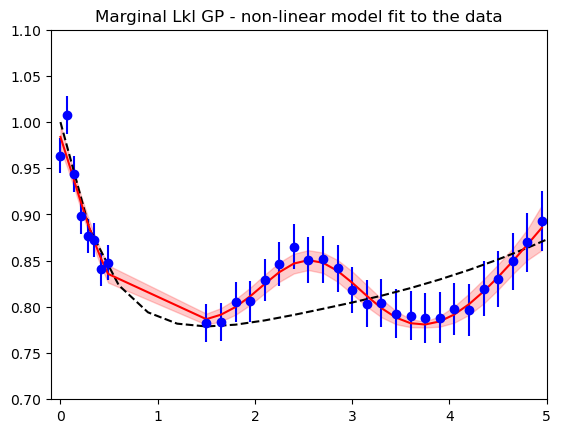

PyObject Text(0.5, 1.0, 'Marginal Lkl GP - non-linear model fit to the data')

In [127]:
plt.plot(gp_x, make_non_lin(cosmology.Dz(gp_x)), "k--")
plt.errorbar(vec(data_x), nonlin_data, yerr=nonlin_data_err, fmt="bo")

plt.plot(vec(data_x), vec(nonlin_y_m), "r-")
plt.fill_between(vec(data_x), vec(nonlin_y_m .+ nonlin_y_s),
                 vec(nonlin_y_m .- nonlin_y_s), alpha=0.2, color="red")

plt.ylim(0.7, 1.1)
plt.xlim(-0.1, 5.)
plt.title("Marginal Lkl GP - non-linear model fit to the data")